In [1]:
%load_ext dotenv
%dotenv

In [28]:
from langgraph.graph import START, END, StateGraph, add_messages, MessagesState
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, RemoveMessage, SystemMessage
from collections.abc import Sequence
from typing import Literal, Annotated

In [3]:
chat = ChatOpenAI(model = "gpt-4o-mini", 
                  seed = 365, 
                  temperature = 0, 
                  max_completion_tokens = 100)

In [4]:
def ask_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "What is your question?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [5]:
def chatbot(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
    
    response = chat.invoke(state["messages"])
    response.pretty_print()
    
    return MessagesState(messages = [response])

In [6]:
def ask_another_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [7]:
def trim_messages(state: MessagesState) -> MessagesState:
    print(f"\n-------> ENTERING trim_messages:")
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:-5]]
    
    return MessagesState(messages = remove_messages)

In [8]:
def routing_function(state: MessagesState) -> Literal["trim_messages", "__end__"]:
    if state["messages"][-1].content == "yes":
        return "trim_messages"
    else:
        return "__end__"

In [9]:
graph = StateGraph(MessagesState)

In [10]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("trim_messages", trim_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("trim_messages", "ask_question")

In [11]:
graph_compiled = graph.compile()

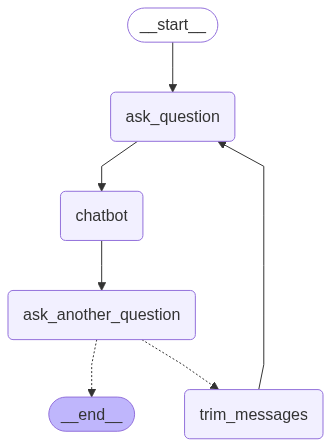

In [12]:
graph_compiled

In [13]:
graph_compiled.invoke(MessagesState(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

How old is Piet Hein
================================== Ai Message ==================================

Piet Hein, the Dutch poet, scientist, and philosopher, was born on December 16, 1905, and passed away on April 17, 1996. If we calculate his age as of now, in October 2023, he would have been 117 years old.

-------> ENTERING ask_another_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

How old is Piet Hein
================================== Ai Message ==================================

Piet Hein, the Dutch poet, scientist, and philosopher, was born on December 16, 1905, an

{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='33ff085f-173e-4b9f-9608-32a0d6484192'),
  HumanMessage(content='Where was he born?', additional_kwargs={}, response_metadata={}, id='38afb297-b66f-4fcb-9e0a-6d4fa79edd29'),
  AIMessage(content='Piet Hein was born in Groningen, Netherlands.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 124, 'total_tokens': 134, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-Bn0PTgzdnSVVqpfiPxpXoQeAH95Y7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d2acfab2-687f-4d5b-810a-01aa7af3260d-0', usage_metadata={'input_tokens': 124, 'output_tokens': 10, 

## Summarizing messages

In [14]:
class State(MessagesState):
    summary: str

In [15]:
test_state = State()

In [16]:
test_state["summary"]

KeyError: 'summary'

In [17]:
bool(test_state.get("summary", ""))

False

In [18]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [20]:
def ask_another_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_another_question:")
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [21]:
def summarize_and_delete_messages(state: State) -> State:
    print(f"\n-------> ENTERING trim_messages:")
    
    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
        
    summary_instructions = f'''
    Update the ongoing summary by incorporating the new lines of conversation below.  
    Build upon the previous summary rather than repeating it so that the result  
    reflects the most recent context and developments.
    
    
    Previous Summary:
    {state.get("summary", "")}
    
    New Conversation:
    {new_conversation}
    '''
    
    print(summary_instructions)
    
    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]
    
    return State(messages = remove_messages, summary = summary.content)

In [22]:
def routing_function(state: State) -> Literal["summarize_and_delete_messages", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "summarize_and_delete_messages"
    else:
        return "__end__"

In [23]:
graph = StateGraph(State)

In [24]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("summarize_and_delete_messages", summarize_and_delete_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("summarize_and_delete_messages", "ask_question")

In [25]:
graph_compiled = graph.compile()

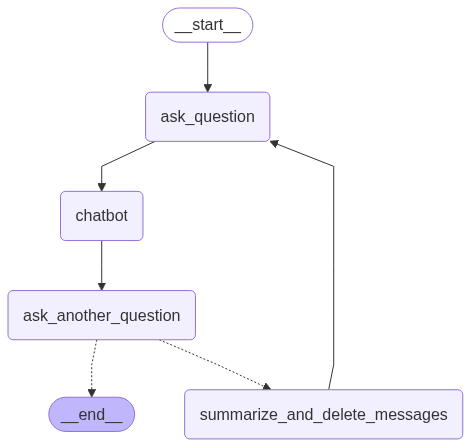

In [26]:
graph_compiled

In [29]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

How old is Piet Hein?
================================== Ai Message ==================================

Piet Hein, the Dutch poet, philosopher, and scientist, was born on December 16, 1905, and passed away on April 17, 1996. If we calculate his age as of today, October 2023, he would have been 117 years old.

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?

-------> ENTERING trim_messages:

    Update the ongoing summary by incorporating the new lines of conversation below.  
    Build upon the previous summary rather than repeating it so that the result  
    reflects the most recent context and developments.
    
    
    Previous Summary:
    
    
    New Conversation:
    a

{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='f7f1713e-d9d5-40cc-b11b-3e18f5c5699b'),
  HumanMessage(content='where is he from?', additional_kwargs={}, response_metadata={}, id='5444eda3-0586-405e-8316-8bfc363ab233'),
  AIMessage(content='Piet Hein was from the Netherlands. He was born in the city of Groningen.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 153, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bn0ZOt3sC0cLFULpf46OTNCyOrNv4', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c6400f90-be3b-4d5e-a689-cbe2f49fd685-0', usage_metadata={'input_tokens':